# The Monge-Ampere equation

This notebook presents a series of methods for numerically solving the Monge-Ampere equation
$$
    f(x) - \det(\nabla^2 u(x)) = 0,
$$
among convex functions, with Dirichlet boundary conditions. 
The function $f$ is assumed to be strictly positive.
For that purpose, we rely on the monotone and consistent MA-LBR numerical scheme (Monge-Ampere using Lattice Basis Reduction), and some variants.

*Summary of this series of notebooks:*
[Adaptive grid discretizations, summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/Summary.ipynb)

**References.**

The MA-LBR scheme was first introduced in:
* Benamou, J.-D., Collino, F., & Mirebeau, J.-M. (2016). Monotone and Consistent discretization of the Monge-Ampere operator. Mathematics of Computation, 85(302), 2743â€“2775.

**Reformulation as an extremal operator.**
The starting point of these methods is to observe that, for a positive definite $d \times d$ matrix $M$
$$
    d ({\rm det} M)^\frac 1 d = \inf_{{\rm det} D = 1} {\rm tr}(D M),
$$
where, implicitly, the optimization variable $D$ is also assumed to be a symmetric positive definite matrix.

If $M = \nabla^2 u$ is a hessian matrix, then the l.h.s. is (a multiple of a power of) the Monge-Ampere operator, while the r.h.s. is an infimum of second order linear operators, which can be discretized using monotone finite differences.

**Discretization strategy**
The chosen finite difference scheme for the linear operator is described in 
[I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)
Since 


## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import Selling
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import AutomaticDifferentiation as ad

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time

Some utility functions

In [3]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

def as_field(u,shape):
    ndim = len(shape)
    if u.ndim>=ndim and u.shape[-ndim:]==shape: return u
    else: return ad.broadcast_to(u.reshape(u.shape+(1,)*ndim), u.shape+shape)

In [4]:
def solve_Newton(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = guess+ad.Sparse.identity(guess.shape)
    for i in range(niter):
        start_time = time.time()
        residue = Scheme(u,*params)
        residue_time = time.time()
        u += (residue + relax).solve()
        solve_time = time.time()
        if (i-1)%print_period ==0  or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue)) # Before solve
            print("timing. Residue :",residue_time-start_time,"Solve :",solve_time-residue_time,
                  "size_ad :",residue.size_ad)
    return np.array(u)

def solve_DampedNewton(Scheme,params,guess,print_period=1,niter=8,relax=0.,damping_criterion=None):
    u = guess+ad.Sparse.identity(guess.shape)
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0  or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue)) # Before solve
        direction = (residue + relax).solve()
        step = 1.
        while damping_criterion(np.array(u)+step*direction):
            step/=2
#        print("step used :", step)
        u += step*direction
    return np.array(u)

In [5]:
def reload_packages():
    import importlib
    Selling = importlib.reload(sys.modules['NumericalSchemes.Selling'])
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    fd = importlib.reload(sys.modules['NumericalSchemes.FiniteDifferences'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)

## 1. Naive non-monotone discretization (purposedly fails)

We present a naive, non-monotone discretization of the addressed problem. This scheme can be used to check that a numerical solution (produced by other means) is correct, or to construct synthetic examples. However, using it to solve the PDE is usually bound to fail. 

The naive scheme is based on a reconstruction of the Hessian matrix of the form
$$
    \begin{pmatrix}
        D^h_{00} u(x) & D^h_{01} u(x)\\
        D^h_{01} u(x) & D^h_{11} u(x)
    \end{pmatrix},
$$
where $D_{00}$, $D_{01}$ and $D_{11}$ are finite-difference operators. Namely
$$
    D^h_{00} u(x) := \frac{u(x_0+h,x_1)-2 u(x_0,x_1) + u(x_0-h,x_1)}{h^2},
$$
likewise for $D^h_{11} u(x)$, and finally
$$
    D^h_{01} u(x) := \frac{u(x_0+h,x_1+h)-u(x_0-h,x_1+h)-u(x_0+h,x_1-h)+h(x_0-h,x_1-h)}{4 h^2}.
$$

In [6]:
def SchemeNonMonotone(u,f,bc,h):
    # Compute the hessian matrix of u
    uxx = fd.Diff2(u,(1,0),h)
    uyy = fd.Diff2(u,(0,1),h)
    uxy = 0.25*(fd.Diff2(u,(1,1),h) - fd.Diff2(u,(1,-1),h))
    
    # Numerical scheme
    det = uxx*uyy-uxy**2
    residue = f - det
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

We next choose some problem parameters

In [7]:
# Create the domain
gridScale = 0.02
aX0 = np.arange(-1,1,gridScale); aX1=aX0;
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

guess = X0**2+X1**2

# Set the boundary conditions 
bc=np.full(X0.shape,0.)
bc[1:-1,1:-1] = np.nan

# Choose the PDE parameters
f=1.

The naive and non-monotone discretization scheme is consistent, but lacks any other sort of theoretical guarantees. 

**In general, attempts to solve numerically the non-monotone scheme will fail. This is expected behavior**

In [8]:
params = (f,bc,gridScale)
#solution = solve_Newton(SchemeNonMonotone,params,guess,print_period=2,niter=15) # Fails (quickly). Run if you dare

The non-monotone scheme may nevertheless work for some specific gentle problem instances (with a smooth solution), a careful initialization, and a bit of luck.

This is the case below, where we solve the same problem as above, but with a different handling of the boundary conditions: they are imposed them implicitly by the padding values used in the finite differences.

Iteration : 1 , Residue norm : 6139649.490881566
timing. Residue : 0.021872758865356445 Solve : 0.08393120765686035 size_ad : 12
Iteration : 3 , Residue norm : 383707.253507626
timing. Residue : 0.01888585090637207 Solve : 0.07655692100524902 size_ad : 12
Iteration : 5 , Residue norm : 23950.95857074562
timing. Residue : 0.018969058990478516 Solve : 0.07675790786743164 size_ad : 12
Iteration : 7 , Residue norm : 1470.1610039651907
timing. Residue : 0.018372058868408203 Solve : 0.0752878189086914 size_ad : 12
Iteration : 9 , Residue norm : 71.89670146282235
timing. Residue : 0.018674373626708984 Solve : 0.0789177417755127 size_ad : 12
Iteration : 11 , Residue norm : 0.23687266600068568
timing. Residue : 0.0352482795715332 Solve : 0.11854696273803711 size_ad : 12
Iteration : 13 , Residue norm : 1.2143885896875872e-10
timing. Residue : 0.01839303970336914 Solve : 0.08165597915649414 size_ad : 12
Iteration : 14 , Residue norm : 2.6150193122020937e-12
timing. Residue : 0.024966955184936523 

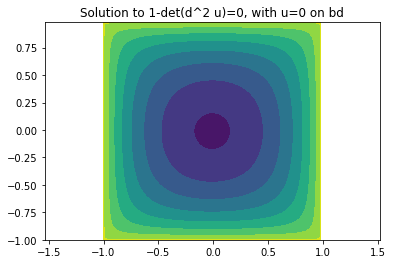

In [9]:
params = (f,np.full(X0.shape,np.nan),gridScale)
solution_non_monotone = solve_Newton(SchemeNonMonotone,params,guess,print_period=2,niter=15) 

plt.axis('equal'); plt.title("Solution to 1-det(d^2 u)=0, with u=0 on bd")
plt.contourf(X0,X1,solution_non_monotone);

## 1. The MA-LBR scheme

The MA-LBR scheme is a monotone and consistent discretization of the Monge-Ampere operator. It takes the form:
$$
    \Lambda u(x) := \inf_{(e_0,e_1,e_2) \in S} H( \Delta_{e_0}^h u(x), \Delta_{e_1}^h u(x), \Delta_{e_2}^h u(x)).
$$
We denoted by $S$ a family of superbases of $Z^2$, which is a parameter to the scheme that must be chosen, see below. 
Superbases are triplets $(e_0,e_1,e_2)$ of vectors $e_0,e_1,e_2 \in Z^2$ with integer coordinates.

We denoted second order finite differences, in a direction $e\in Z^2$ by 
$$
    \Delta_e^h u(x) := \frac{u(x+h e) -2 u(x) +u(x+he)} {h^2}.
$$
The scheme also features a three argument function $H$, defined as follows: $H(a,b,c) := H_0(a_+,b_+,c_+)$, where 
$$
    H_0(a,b,c) :=
    \begin{cases}
        a b \quad \text{ if }\ a+b < c, \text{ and likewise permuting } a,b,c\\
        \frac 1 2 (a b+b c+c a) - \frac 1 4 (a^2+b^2+c^2)\quad \text{ otherwise}.
    \end{cases}
$$


**Convexity of the solution, and ellipticity of the PDE and numerical scheme.**

The Monge-Ampere equation imposes, as a constraint, that the solution $u$ be convex. The ellipticity of the Monge-Ampere operator degenerates as $\det(\nabla^2 u) \to 0$, which means that $u$ looses convexity.

A similar issue arises with the MA-LBR scheme. It is strictly elliptic only as long as 
$$
    \Lambda u(x) > 0,
$$
which is a discrete counterpart of convexity. 

**Damping of the Newton method**
We need to guarantee that, along the iterations, the numerical scheme ellipticity is preserved. 
A first requirement for this is to choose a strictly convex initialization, for instance the quadratic function $u(x) = \|x\|^2/2$.

For this reason, we also resort to a damped Newton method. More specifically
$$
    u_{n+1} = u_n + 2^{-k_n} d_n,
$$
where $d_n$ is the Newton descent direction, and $k_n$ is the least integer such that 
$$
    \Lambda u_{n+1}(x) \geq f(x)/2,
$$
at all discretization points $x$.
(Recall that the r.h.s $f$ is assumed to be strictly positive.)

In [10]:
guess_quadratic = 0.5*(X0**2+X1**2)

In [11]:
def MALBR_H(d2u):
    a,b,c = ad.sort(np.maximum(0.,d2u), axis=0)
    
    # General formula, handling infinite values separately
    A,B,C = (ad.where(e==np.inf,0.,e) for e in (a,b,c))
    result = 0.5*(A*B+B*C+C*A)-0.25*(A**2+B**2+C**2)
    
    pos_inf = np.logical_or.reduce(d2u==np.inf)    
    result[pos_inf]=np.inf
    
    pos_ineq = a+b<c
    result[pos_ineq] = (A*B)[pos_ineq]
        
    return result
    
def SchemeMALBR(u,SB,f,bc,gridScale):
    # Compute the finite differences along the superbase directions
    d2u = fd.Diff2(u,SB,gridScale,padding=np.inf)
    
    # Numerical scheme
    residue = f-MALBR_H(d2u).min(axis=0)
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

def DampingMALBR(u,SB,f,bc,gridScale):
    residue = SchemeMALBR(u,SB,f,bc,gridScale)
    interior = np.isnan(bc)
    return np.any(residue[interior]>=f/2)

We next choose a family of superbases. The scheme is (second order) consistent while the condition number of the hessian of $u$ remains below the given bound. Beyond that, a consistency defect is introduced.

In [12]:
SB0 = Selling.SuperbasesForConditioning(5)
SB1 = Selling.SuperbasesForConditioning(15)
SB2 = Selling.SuperbasesForConditioning(30)

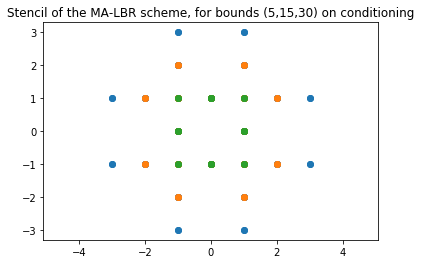

In [13]:
plt.axis('equal'); plt.title('Stencil of the MA-LBR scheme, for bounds (5,15,30) on conditioning')
def stencil(SB): return np.stack((SB,-SB),axis=2)[:,:]
plt.scatter(*stencil(SB2));plt.scatter(*stencil(SB1));plt.scatter(*stencil(SB0));

In [14]:
params = (SB0,f,bc,gridScale)
def damping_criterion(u): return DampingMALBR(u,*params)
solution_MALBR = solve_DampedNewton(SchemeMALBR,params,guess_quadratic,print_period=2,niter=30,
                                   damping_criterion=damping_criterion) 

Iteration : 1 , Residue norm : 0.875
Iteration : 3 , Residue norm : 0.8211669921875
Iteration : 5 , Residue norm : 0.783075749874115
Iteration : 7 , Residue norm : 0.7467514353047591
Iteration : 9 , Residue norm : 0.7121120864991184
Iteration : 11 , Residue norm : 0.6683005030523953
Iteration : 13 , Residue norm : 0.5873734890108944
Iteration : 15 , Residue norm : 0.449707827523966
Iteration : 17 , Residue norm : 0.4021199921344447
Iteration : 19 , Residue norm : 0.3060406214860265
Iteration : 21 , Residue norm : 0.03969770560325969
Iteration : 23 , Residue norm : 3.438768203523068e-08
Iteration : 25 , Residue norm : 1.8838264281839656e-12
Iteration : 27 , Residue norm : 1.567634910770721e-12
Iteration : 29 , Residue norm : 1.9984014443252818e-12


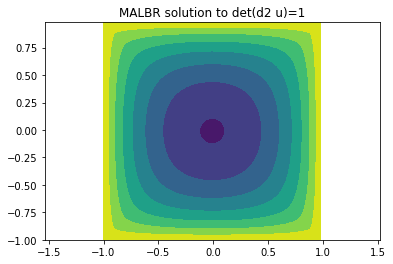

In [15]:
plt.axis('equal'); plt.title("MALBR solution to det(d2 u)=1")
plt.contourf(X0,X1,solution_MALBR);

## 3. Uniformly elliptic scheme

We reformulate the PDE as 
$$
    0 = \max_D \det(D)^\frac 1 d - \alpha(x) {\rm tr} (D \nabla ^2 u(x))
$$
subject to the constraints
$$
    D \succeq 0, \qquad {\rm tr} (D) = 1,
$$
and where we denoted
$$
    \alpha(x) := 1/(d f(x)^{\frac 1 d}).
$$

### Reformulation as a quadratic optimization problem

We constrain the above optimization problem to matrices $D$ which can be decomposed over a superbase $(e_0,e_1,e_2)$ of $Z^2$ in the form
$$
    D = \sum_i v_i e_i e_i^T,
$$
where $v_i \geq 0$, $0 \leq i \leq 2$.
We can compute the trace of $D$ 
$$
    {\rm tr}(D) = \sum_i v_i \|e_i\|^2,
$$
and its determinant
$$
    \det(D) = v_0 v_1 + v_1 v_2 + v_2 v_0 = <v,Q v>
$$
where 
$$
    Q = \frac 1 2 \begin{pmatrix} 0 & 1 & 1\\ 1 & 0 & 1\\ 1 & 1 & 0 \end{pmatrix}
$$
In addition, we have the finite differences approximation
$$
    {\rm tr}(D \nabla^2 u(x)) \approx \sum_i v_i \frac{ u(x+h e_i)-2 u(x)+u(x-he_i)} {h^2}
$$


### Solving a low dimensional constrained optimization problem
We need to solve the concave maximization problem 
$$
    \max_v \sqrt{<v,Q v>} + <l,v>
$$
subject to the constraints
$$
    v \succeq 0, \qquad <m,v>=1.
$$

Assuming the positivity constraints are inactive at the maximizer, we obtain the optimality relation
$$
    \frac {Q v}{\sqrt{<v,Q v>}} + l = \mu m,
$$
for some Lagrange multiplier $\mu \in R$.

**Solving the problem.**
A quadratic equation obeyed by this multiplier
$$
    <(\mu m -l), Q^{-1} (\mu m -l)> = 1.
$$
(Which root is to be selected ?)
The minimizer can be obtained by 
$$
    \frac{v}{\sqrt{<v,Q v >}} = Q^{-1} (\mu m -l)
$$

In [20]:
def ConstrainedMaximize(Q,l,m):
    dim = l.shape[0]
    if dim==1:
        return (l[0]+np.sqrt(Q[0,0]))/m[0]
    
    # Discard infinite values, handled afterwards
    pos_bad = l.min(axis=0)==-np.inf
    L = l.copy(); L[:,pos_bad]=0
    
    # Solve the quadratic equation
    A = lp.inverse(Q)    
    lAl = lp.dot_VAV(L,A,L)
    lAm = lp.dot_VAV(L,A,m)
    mAm = lp.dot_VAV(m,A,m)
    
    delta = lAm**2 - (lAl-1.)*mAm
    pos_bad = np.logical_or(pos_bad,delta<=0)
    delta[pos_bad] = 1.
    
    mu = (lAm + np.sqrt(delta))/mAm
    
#    print("mu",mu.size_ad,"lAl",lAl.size_ad,"lAm",lAm.size_ad,"l",l.size_ad)
    # Check the positivity
#    v = dot_AV(A,mu*m-L)
    rm_ad = np.array
    v = lp.dot_AV(rm_ad(A),rm_ad(mu)*rm_ad(m)-rm_ad(L))
    pos_bad = np.logical_or(pos_bad,np.any(v<0,axis=0))
    
    result = mu
    result[pos_bad] = -np.inf
    
    # Solve the lower dimensional sub-problems
    # We could restrict to the bad positions, and avoid repeating computations
    for i in range(dim):             
        axes = np.full((dim),True); axes[i]=False
        res = ConstrainedMaximize(Q[axes][:,axes],l[axes],m[axes])
        result = np.maximum(result,res)
    return result

In [17]:
def SchemeUniform(u,SB,f,bc,h):
    # Compute the finite differences along the superbase directions
    d2u = fd.Diff2(u,SB,gridScale) #,padding=np.inf)
    
    # Generate the parameters for the low dimensional optimization problem
    Q = 0.5*np.array([[0,1,1],[1,0,1],[1,1,0]])
    dim = 2
    l = -d2u/(dim * f**(1/dim))
    m = (SB**2).sum(0)

    # Evaluate the numerical scheme
    m = as_field(m,u.shape)
    Q = as_field(Q,m.shape[1:])
    residue = ConstrainedMaximize(Q,l,m).max(axis=0)
    
    # Boundary conditions
    return ad.where(np.isnan(bc),residue,u-bc)

In [18]:
#%%time
#SchemeUniform(guess_quadratic+ad.Sparse.identity(X0.shape),*params)

In [21]:
params = (SB0,f,bc,gridScale)
solution_Uniform = solve_Newton(SchemeUniform,params,guess_quadratic,print_period=2) 

Iteration : 1 , Residue norm : 1.9461602823015034
timing. Residue : 0.9553289413452148 Solve : 0.0786750316619873 size_ad : 54
Iteration : 3 , Residue norm : 0.2509001683967279
timing. Residue : 0.9467918872833252 Solve : 0.07403302192687988 size_ad : 54
Iteration : 5 , Residue norm : 0.004386125288393883
timing. Residue : 0.9587581157684326 Solve : 0.07329201698303223 size_ad : 54
Iteration : 7 , Residue norm : 1.0458235630839141e-06
timing. Residue : 0.9486756324768066 Solve : 0.07371211051940918 size_ad : 54


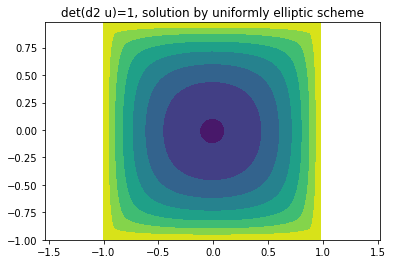

In [22]:
plt.axis('equal'); plt.title("det(d2 u)=1, solution by uniformly elliptic scheme")
plt.contourf(X0,X1,solution_Uniform);